# Model Evaluation

## Import Libraries

In [4]:
from tensorflow.keras.models import load_model
import pandas as pd
from PIL import Image
import numpy as np
import cv2

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

from src import outputs_dir
from src.__00__paths import model_dir, data_dir, docs_dir, figures_dir

## Load Model

In [5]:
model = load_model(model_dir / "custom_traffic_classifier.h5")

2025-07-31 12:43:05.177277: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2025-07-31 12:43:05.177313: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-07-31 12:43:05.177317: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
I0000 00:00:1753954985.177330 1627813 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1753954985.177350 1627813 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## Load and Prepare Datasets

In [6]:
test_df = pd.read_csv(data_dir / "Test.csv")
test_df.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,53,54,6,5,48,49,16,Test/00000.png
1,42,45,5,5,36,40,1,Test/00001.png
2,48,52,6,6,43,47,38,Test/00002.png
3,27,29,5,5,22,24,33,Test/00003.png
4,60,57,5,5,55,52,11,Test/00004.png


In [7]:
from PIL import Image
import numpy as np

test_images = []
test_labels = []
skipped_images = []

for _, row in test_df.iterrows():
    image_path = data_dir / row["Path"]
    try:
        image = Image.open(image_path)
        image = image.resize((30, 30))
        test_images.append(np.array(image))
        test_labels.append(row["ClassId"])
    except Exception as e:
        skipped_images.append(image_path)
        print(f"Skipped corrupted image at {'/'.join(image_path.parts[-2:])}")

# Convert to NumPy arrays and normalize
x_test = np.array(test_images)
y_test = np.array(test_labels)

Skipped corrupted image at Test/00802.png


## Predict Outputs

In [8]:
pred_probs = model.predict(x_test)
y_pred = np.argmax(pred_probs, axis=1)

 39/395 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

2025-07-31 12:43:09.022369: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


395/395 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


## Confusion Matrix & Report

Test Accuracy: 96.23%

Classification Report:

              precision    recall  f1-score   support

           0       0.98      1.00      0.99        60
           1       0.98      0.99      0.98       720
           2       0.97      0.99      0.98       750
           3       0.96      0.95      0.95       450
           4       0.99      0.98      0.99       660
           5       0.89      0.94      0.92       629
           6       0.99      0.85      0.91       150
           7       1.00      0.93      0.96       450
           8       0.97      0.93      0.95       450
           9       0.96      1.00      0.98       480
          10       0.98      0.98      0.98       660
          11       0.99      0.95      0.97       420
          12       1.00      0.96      0.98       690
          13       1.00      0.98      0.99       720
          14       1.00      1.00      1.00       270
          15       0.94      1.00      0.97       210
          16       0.99      0.99 

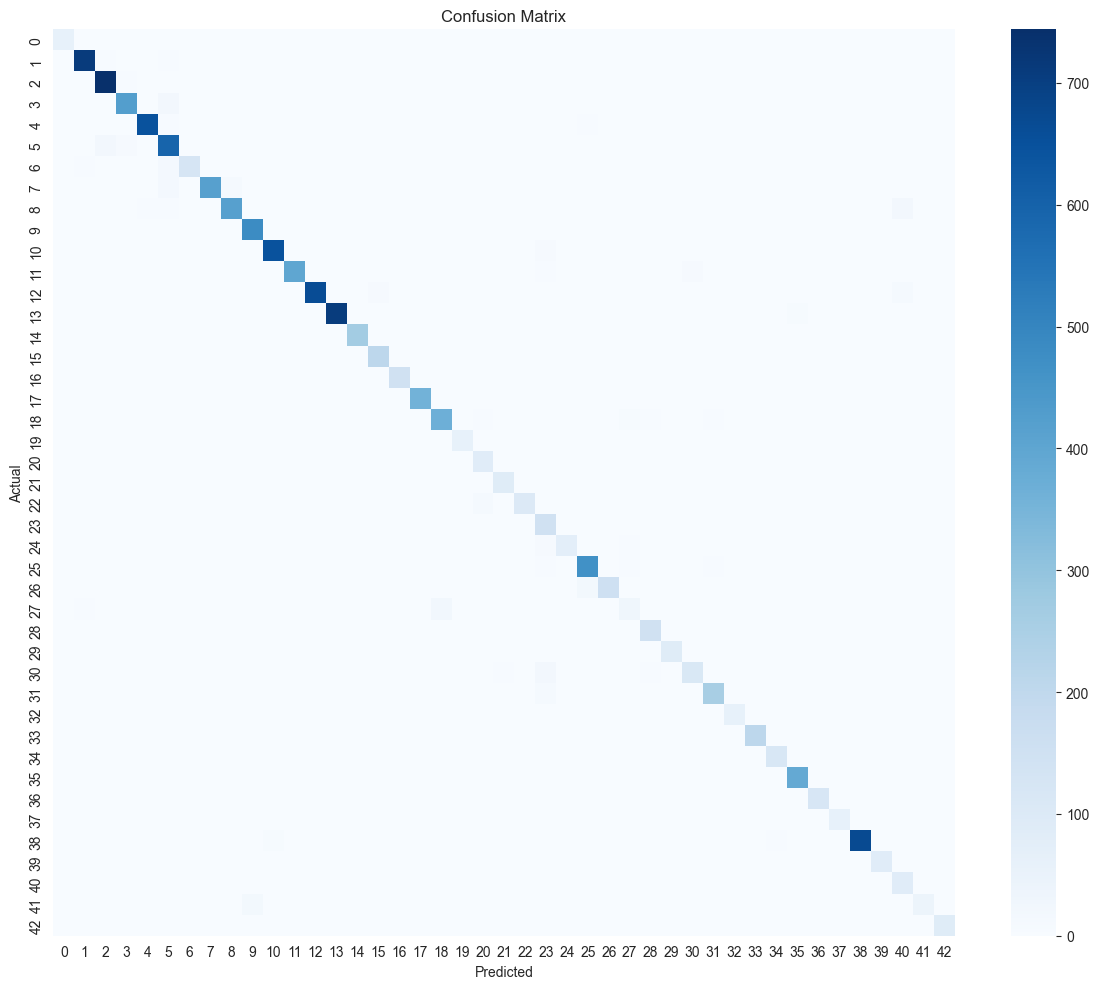

In [10]:
# Calculate predictions
accuracy = accuracy_score(y_test, y_pred) * 100
report = classification_report(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

# 1. Print to console
print(f"Test Accuracy: {accuracy:.2f}%")
print("\nClassification Report:\n")
print(report)

# 2. Save classification report to file
report_path = docs_dir / "classification_report.txt"
with open(report_path, "w") as f:
    f.write(f"Test Accuracy: {accuracy:.2f}%\n\n")
    f.write("Classification Report:\n")
    f.write(report)

print(f"Classification report saved to: {'/'.join(report_path.parts[-3:])}")

# 3. Save confusion matrix plot
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=False, cmap="Blues", fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.savefig(figures_dir / "confusion_matrix.png", dpi=300)
plt.show()